In [3]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_MOI2D, get_Pendulum_Invariance, get_SHM_Invariance, get_SHM2D_Invariance, get_Double_Pendulum_Invariance
from invariance_functions import degree_of_freedom, get_GPR_2Dmodel, get_SHM2D_data, evaluate_2Dmodel, get_double_pendulum_data
from local_invariance_kernels import  get_Polynomial_2D_Local_Invariance
from parameterised_invariance_kernels import get_Polynomial_2D_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
mean = zero_mean(4)

time_step = 0.01
training_time = 0.1
testing_time = 0.1

max_x = 3
n_train = 2
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5, (n_train))
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)

data = get_SHM2D_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch
test_data = get_SHM2D_data(time_step, testing_time, 1e-8,[test_starting_position1],[test_starting_position2],[test_starting_velocity1],[test_starting_velocity2] )
for jitter in [1e-6]:
    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
#    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
#    print(evaluate_moi[:2])
    for invar_density in [10]: #np.arange(10, 30, 10):
            try:
                polynomial_degree = 1
#                kernel = get_Polynomial_2D_Local_Invariance(3, 40, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                kernel = get_Polynomial_2D_Invariance(3, invar_density, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                m = get_GPR_2Dmodel(kernel, mean, data, 500)
                print(round(m.log_marginal_likelihood().numpy()))
#                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
#                print(evaluate_invariance[:2])
                print(kernel.f1_poly)
                print(kernel.f2_poly)
                print(kernel.g1_poly)
                print(kernel.g2_poly)

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 


[1.33062884 2.0727425 ]
[ 1.58948895 -2.73812109]
[0.52805794 0.19906099]
[ 0.39307624 -0.51945532]
2.7813776773399805
-2.619534213216814
-0.036437861583165754
0.5080317602259657
271, 


In [18]:

from itertools import combinations_with_replacement
A = tf.Variable(np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]),shape=(3,4),dtype=tf.float64)
polynomial_X = tf.ones((A.shape[0],1),dtype=tf.float64)
for d in range(1,1+1):
    indices = list(combinations_with_replacement(range(4),d))
    for index in indices:
        sub_polynomial_X = tf.ones((A.shape[0],1),dtype=tf.float64)
        for i in index:
            sub_polynomial_X = tf.multiply(sub_polynomial_X,A[:,i,None])
        polynomial_X = tf.concat([polynomial_X, sub_polynomial_X], 1)

tf.squeeze(tf.linalg.matmul(polynomial_X,tf.Variable([0,1,0,0,0],dtype=tf.float64)[:,None]))

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1., 5., 9.])>

In [19]:
polynomial_X

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[ 1.,  1.,  2.,  3.,  4.],
       [ 1.,  5.,  6.,  7.,  8.],
       [ 1.,  9., 10., 11., 12.]])>

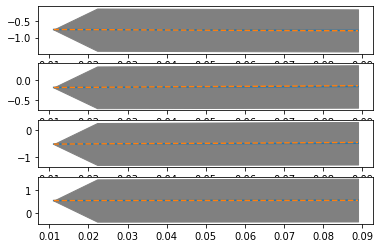

In [2]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[2][:,0])
axs[0].fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_moi[2][:,1])
axs[1].fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_moi[2][:,2])
axs[2].fill_between(t,evaluate_moi[2][:,2]+1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,2]-1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_moi[2][:,3])
axs[3].fill_between(t,evaluate_moi[2][:,3]+1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,3]-1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

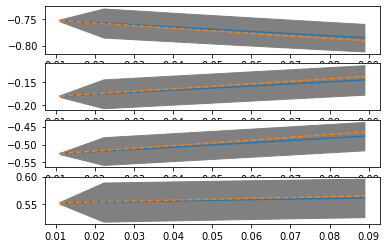

In [3]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')